# Определение стоимости автомобилей

Заказчик: сервис по продаже автомобилей с пробегом.
Необходимо разработать модель для прогнозирования цены автомобиля. Модель будет использоваться в приложении, где потенциальныме клиенты смогут быстро узнать стоимость своего автомобиля.

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

Одно из требований заказчика: метрика RMSE < 2500

**Данные**
Файл autos.csv

Признаки:

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    Repaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

Целевой признак: Price — цена (евро)

## План работы

- Загрузить и подгоовить данные
- Обучить разные модели
- Проанлизировать скорость работы и качество омделей
- Выбрать лучшую модель

Для оценки качества моделей будет применена метрика RMSE


## Подготовка данных

### Загрузка библиотек и датасетов

In [1]:
#установка недостающих библиотек  и недостающих обновлений в окружение
!pip install shap -q
!pip install phik -q
!pip install -U scikit-learn -q

In [2]:
#импорт библиотек и определение констант
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from lightgbm import LGBMRegressor

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import tree


from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)
 
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression )

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import root_mean_squared_error

import warnings

In [3]:
RANDOM_STATE = 42

In [4]:
#игнорирование предупреждений
#warnings.filterwarnings('ignore')

In [5]:
#загрузка файла geo_data_0.csv
data = pd.read_csv('/datasets/autos.csv')
display(data.head())
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Вывод**
Файл autos.csv:
 - число строк: 354 369
 - число столбцов: 16
 - пустые значения: есть
 - типы данных: соответствуют данным в файле
 - переименование столбцов: требуется

### Предобработка данных

#### Переименование столбцов

In [6]:
# переименование столбцов в соответствии с pep8
data.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### Поиск явных дубликатов

In [7]:
#поиск явных дубликатов в датафрейме train_job_satisfaction_rate
data.duplicated().sum()

4

In [8]:
# удаление дубликатов
data = data.drop_duplicates(ignore_index=True)
data.shape[0]

354365

#### Поиск неявных дубликатов

In [9]:
def uniq_df(df, list):
    """
    Функция для получения перечня уникальных значений для параметров датафрейма
    на вход получает датафрейм и список полей для которых нужно получить уникальные значения
    """
    for element in list:
        print(f"Уникальные значения для поля {element}")
        print(df[element].sort_values().unique(), '\n')    

In [10]:
# получение уникальных значений для категориальных признаков

uniq_df(data, ['vehicle_type', 'gearbox',
       'model', 'fuel_type', 'brand', 'repaired'])

Уникальные значения для поля vehicle_type
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan] 

Уникальные значения для поля gearbox
['auto' 'manual' nan] 

Уникальные значения для поля model
['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 '

#### Обработка полей с датой

In [11]:
#конвертация даты, выделение года и дня года в отдельные параметры
data['date_crawled'] = pd.to_datetime(data['date_crawled'], format='%Y-%m-%d %H:%M:%S')
data['year_crawled'] = data['date_crawled'].dt.year
data['day_crawled'] = data['date_crawled'].dt.dayofyear
data['date_created'] = pd.to_datetime(data['date_created'], format='%Y-%m-%d %H:%M:%S')
data['year_created'] = data['date_created'].dt.year
data['day_created'] = data['date_created'].dt.dayofyear
data['last_seen'] = pd.to_datetime(data['last_seen'], format='%Y-%m-%d %H:%M:%S')
data['year_last'] = data['last_seen'].dt.year
data['day_last'] = data['last_seen'].dt.dayofyear

In [12]:
#удаление столбцов с датами
data = data.drop(['date_crawled', 'date_created', 'last_seen'], axis=1)
data

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,number_of_pictures,postal_code,year_crawled,day_crawled,year_created,day_created,year_last,day_last
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435,2016,84,2016,84,2016,98
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0,66954,2016,84,2016,84,2016,98
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0,90480,2016,74,2016,74,2016,96
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,91074,2016,77,2016,77,2016,77
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0,60437,2016,91,2016,91,2016,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,0,2694,2016,81,2016,81,2016,81
354361,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,0,39576,2016,74,2016,74,2016,97
354362,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,0,26135,2016,65,2016,65,2016,71
354363,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,0,87439,2016,79,2016,79,2016,98


**Вывод** 

Было найдено 4 явных дубликата, которые были удалены.
Неявные дубликаты не были обнаружены.

Также была проведена обработка параметров с датой. Поля с номером года и с номером дня в течение года вынесены в отдельные параметры. Поля с исходной датой удалены из датасета.

### Исследовательский анализ данных

#### Исследование количественных данных

In [13]:
def hist_box_diagramm(df, list):
    """
    функция для строительства гистограммы и ящика с усами.
    на вход получает датафрейм и список полей для которых нужно построить графики
    """
    for element in list:   
        
        # создание объекта из двух: гстограммы и ящика с усами
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})
        
        # назначение графика каждой переменной
        sns.boxplot(df[element], orient='h', ax=ax_box)
        sns.histplot(df, x=element);
        
        print(f"Графики для поля: {element}")

        # удаление подписи для оси х
        ax_box.set(xlabel='')
        plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: price


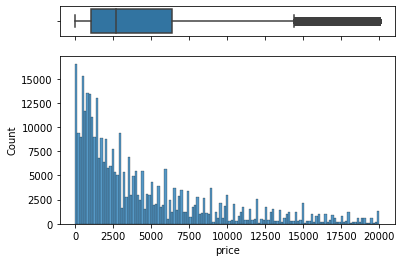

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: registration_year


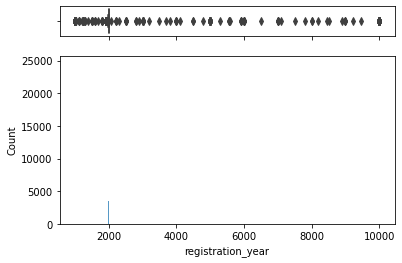

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: power


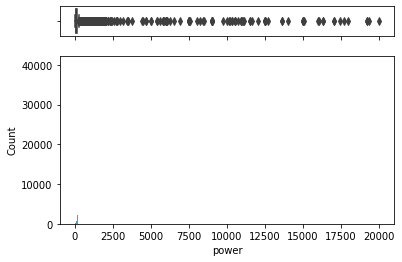

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: kilometer


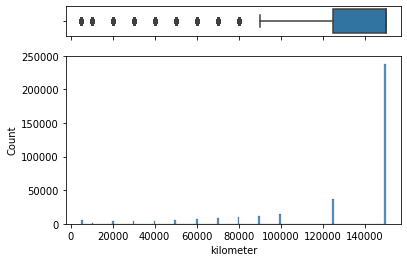

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: registration_month


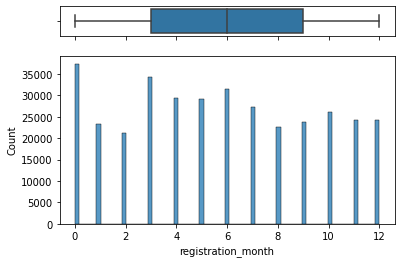

Графики для поля: number_of_pictures


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


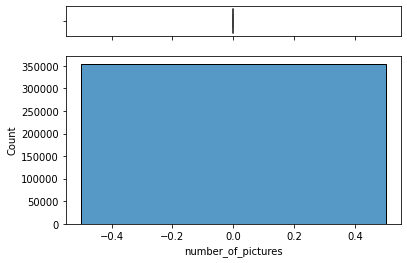

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: postal_code


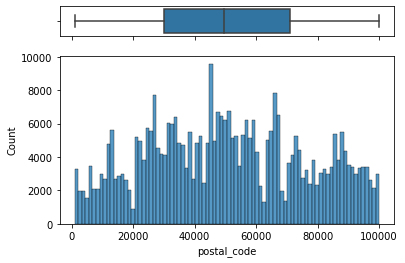

Графики для поля: year_crawled


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


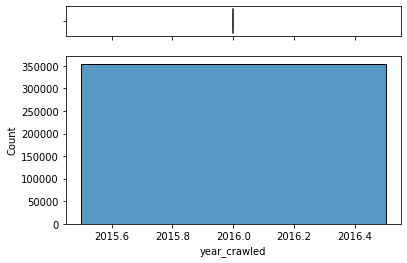

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: day_crawled


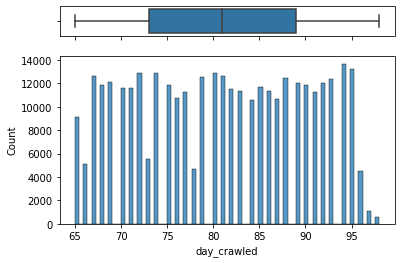

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: year_created


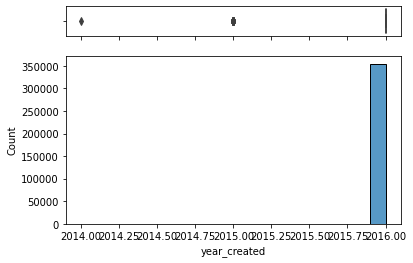

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: day_created


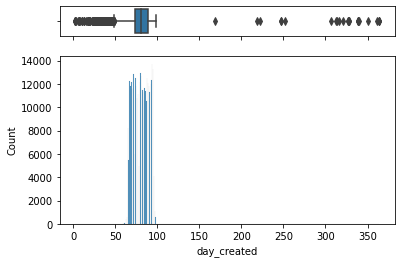

Графики для поля: year_last


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


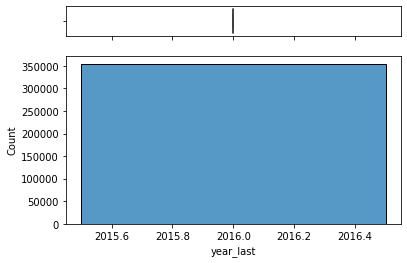

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: day_last


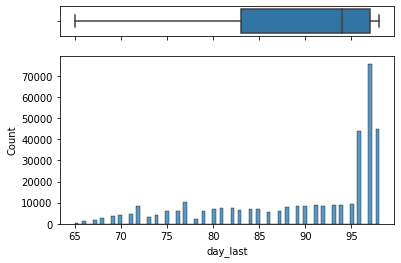

In [14]:
# построение гистрограмм для числовых признаков
hist_box_diagramm(data, ['price', 'registration_year', 'power', 'kilometer', 'registration_month',
                         'number_of_pictures', 'postal_code', 'year_crawled', 'day_crawled', 
                         'year_created', 'day_created', 'year_last', 'day_last'])

#### Редактирование датасета на основе результатов анализа

##### Поле number_of_pictures

In [15]:
# проверка занчений для поля number_of_pictures
data['number_of_pictures'].unique()

array([0])

Исходя из полученных данных, выявлено, что в поле number_of_pictures содержится только одно значение (0). Поэтому сразу удаляем это поле, т.к. оно не несет никакой информации.

In [16]:
#удаление поля number_of_pictures
data = data.drop('number_of_pictures', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354365 non-null  int64 
 1   vehicle_type        316875 non-null  object
 2   registration_year   354365 non-null  int64 
 3   gearbox             334532 non-null  object
 4   power               354365 non-null  int64 
 5   model               334660 non-null  object
 6   kilometer           354365 non-null  int64 
 7   registration_month  354365 non-null  int64 
 8   fuel_type           321470 non-null  object
 9   brand               354365 non-null  object
 10  repaired            283211 non-null  object
 11  postal_code         354365 non-null  int64 
 12  year_crawled        354365 non-null  int64 
 13  day_crawled         354365 non-null  int64 
 14  year_created        354365 non-null  int64 
 15  day_created         354365 non-null  int64 
 16  ye

##### Поле registration_year

Значение года регистрации (поле registration_year) меняется в очень большом диапазоне: от 0 до 10 000. При этом автомобили начали выпускаться только в начале 19 века. Кроме того, выгрузка данных актуальна на 2016 год. Так что дата регистрации не может его превышать. Поэтому registration_year должен быть в диапазоне 1800-2016

In [17]:
# фильтрация года регистрации автомобиля
data = data.query('registration_year > 1800 & registration_year <= 2016')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: registration_year


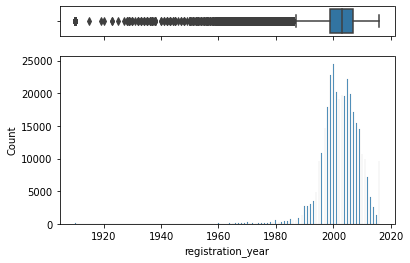

In [18]:
# построение гистрограмм для числовых признаков
hist_box_diagramm(data, ['registration_year'])

После удаления аномальных значений registration_year, график стал выглядеть как нормальное распределение.

##### Поле price

Цена за автомобиль должна быть более 0.

In [19]:
data = data.query('price > 0')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: price


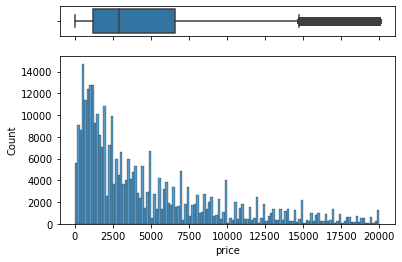

In [20]:
# построение гистрограмм для числовых признаков
hist_box_diagramm(data, ['price'])

##### Поле power

Мощность автомобиля должна быть более 0.

In [21]:
data = data.query('power > 0')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: power


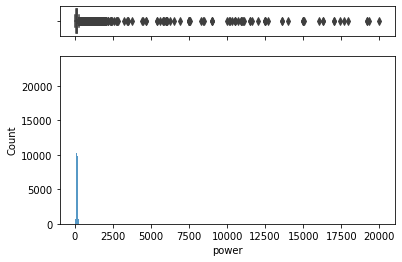

In [22]:
# построение гистрограмм для числовых признаков
hist_box_diagramm(data, ['power'])

##### Поля registration_year, registration_month, postal_code

Данные поля не несут информацию о цене автомобиля. Поэтому для дальнейшего обучения модели их надо удалить из датасета.

In [23]:
data = data.drop(['registration_year', 'registration_month', 'postal_code'], axis=1)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296895 entries, 1 to 354364
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         296895 non-null  int64 
 1   vehicle_type  285821 non-null  object
 2   gearbox       291493 non-null  object
 3   power         296895 non-null  int64 
 4   model         285658 non-null  object
 5   kilometer     296895 non-null  int64 
 6   fuel_type     281259 non-null  object
 7   brand         296895 non-null  object
 8   repaired      253821 non-null  object
 9   year_crawled  296895 non-null  int64 
 10  day_crawled   296895 non-null  int64 
 11  year_created  296895 non-null  int64 
 12  day_created   296895 non-null  int64 
 13  year_last     296895 non-null  int64 
 14  day_last      296895 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 36.2+ MB


#### Исследование категориальных данных

In [27]:
def bar_diagramm(df, list):
    """
    функция для строительства диаграмм типа "пирог".
    на вход получает датафрейм и список полей для которых нужно построить диаграммы.
    """
    for element in list:
        #создание сводной таблицы для подсчета количеств значений признака
        df_pivot = df.pivot_table(index=element, values='power', aggfunc='count') 

        #построение графика 
        df_pivot.plot(kind='bar');
        plt.title(f"Соотношения значений для поля: {element}")
        plt.show()

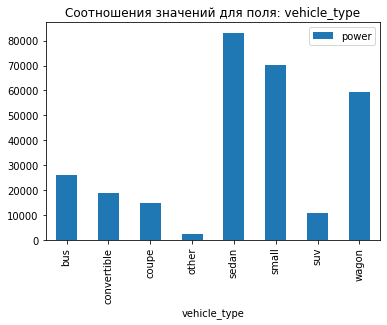

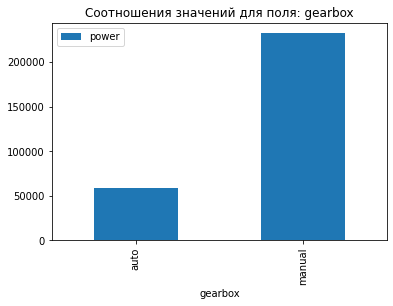

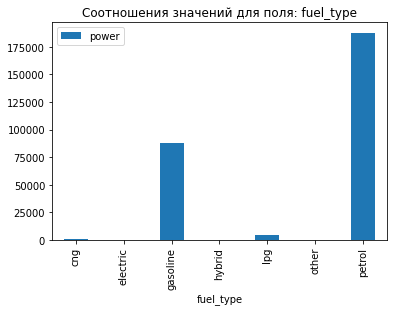

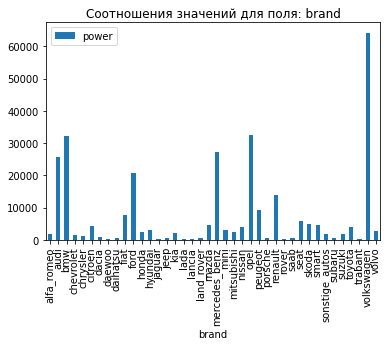

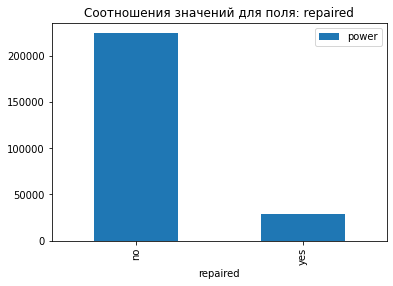

In [28]:
bar_diagramm(data, ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired'])

#### Корреляция

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable year_crawled for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable year_last for analysis 1. Dropping this column
  warnings.warn(


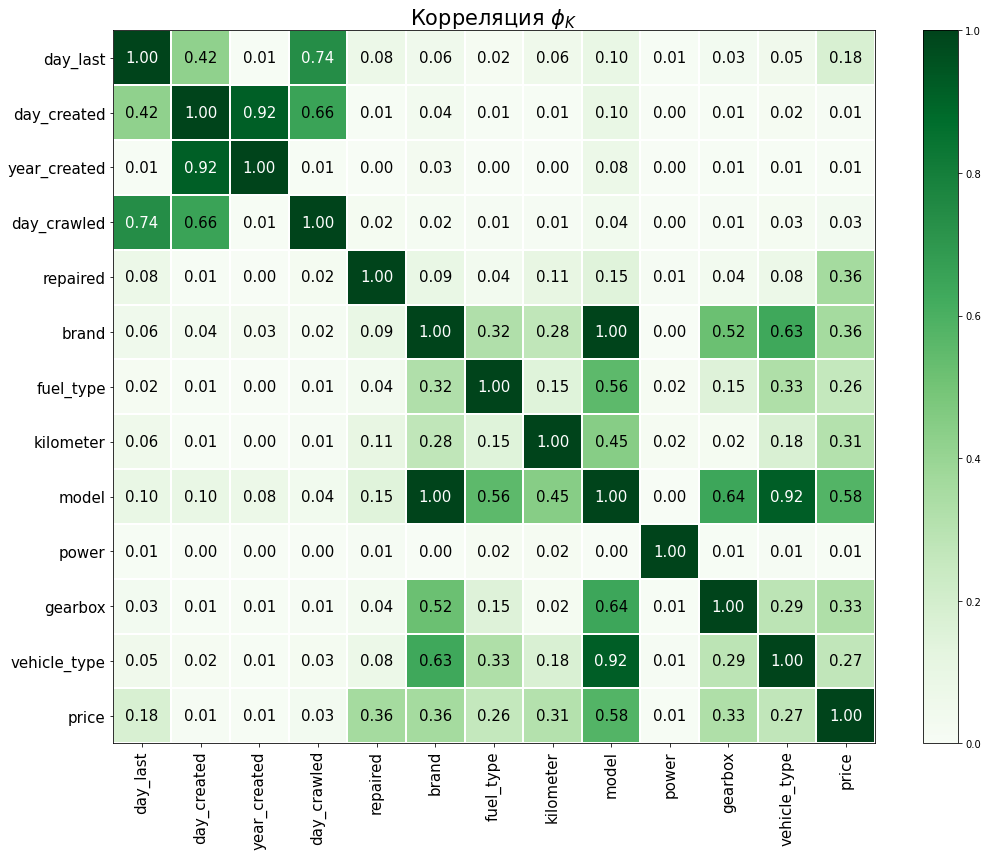

In [30]:
#построим матрицу корреляций phik для более удовлетворенных сотрудников
phik_overview = phik_matrix(data[['price', 'vehicle_type', 'gearbox',
                                 'power', 'model', 'kilometer', 'fuel_type', 'brand',
                                 'repaired', 'year_crawled', 'day_crawled', 
                                 'year_created', 'day_created', 'year_last', 'day_last']], 
                            interval_cols=['price', 'power', 'kilometer', 'year_crawled', 'day_crawled',
                                           'year_created', 'day_created', 'year_last', 'day_last', 'year_crawled', 
                                           'day_crawled', 'year_created', 'day_created', 'year_last', 'day_last'])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 12)
) 

#### Модификация на основе данных о корреляции признаков

Корреляция между model и brand равна 1. model, конечно, играет большую роль при определении цены, но также имеет значение и brand. Есть и други параметры, которые влияют на целевой признак. Для того, чтобы ускорить скорость обучения модели, чтобы не кодировать большое количество признаков в модели, удалим этот признак из датасета для обучения. В дальнейшем проверим на сколько метрики будут соответствовать критерию заказчика.

In [31]:
data = data.drop('model', axis=1)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296895 entries, 1 to 354364
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         296895 non-null  int64 
 1   vehicle_type  285821 non-null  object
 2   gearbox       291493 non-null  object
 3   power         296895 non-null  int64 
 4   kilometer     296895 non-null  int64 
 5   fuel_type     281259 non-null  object
 6   brand         296895 non-null  object
 7   repaired      253821 non-null  object
 8   year_crawled  296895 non-null  int64 
 9   day_crawled   296895 non-null  int64 
 10  year_created  296895 non-null  int64 
 11  day_created   296895 non-null  int64 
 12  year_last     296895 non-null  int64 
 13  day_last      296895 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 34.0+ MB


#### Повторное исследование на дубликаты

Уменьшение количества признаков может приводить к появлению дубликтов. Необходимо првоести проверку и удалить лишние дубликаты.



In [33]:
#проверка наличия дубликатов
data.duplicated().sum()

8494

In [34]:
# удаление дубликатов и проверка удаления
data = data.drop_duplicates()
data.duplicated().sum()

0

**Вывод**

Были проанализированы качественные и количественные признаки.

Было выявлено, что признак number_of_pictures имеет только одно значение. Пэтому был удален из данных для обучения модели.
Также было выявлено, что год регистрации автомобиля имеет аномальные значения. Поэтому были оставлены значения года регистрации более 1800 года и не более 2016 (год актуальности датасета).

При проверке корреляции не было выявлено признаков, которые имеют очень высокую корреляцию с целевым признаком.

Был удален признак model из основного датасета, чтобы уменьшить время на обучение модели (чтобы не кодировать большое количество данных в этом признаке)

Также были удалены нулевые значения для признаков power и price.
А также удалены признаки, которые не влияют на целевой признак: registration_year, registration_month, postal_code.

## Обучение моделей регрессии с учителем

In [35]:
#создание переменных со списками параметров: категориальные, ранговые, числовые
#количественные признаки
num_columns = ['power', 'kilometer', 'year_crawled', 'day_crawled', 
               'year_created', 'day_created', 'year_last', 'day_last']

#категориальные признаки
ohe_columns = ['vehicle_type', 'gearbox', 
               'fuel_type', 'brand', 'repaired']

In [36]:
#разбиение датасета на тренировочне и тестовые выборки
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE) #, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(216300, 13)
(72101, 13)
(216300,)
(72101,)


In [37]:
# пайплайн для обработки категориальных признаков
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        ),
        (
            'simpleImputer_after_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [38]:
# пайплайн для препроцессинга
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [39]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
) 

In [40]:
#параметры для кросс-валидации

param_distributions = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(15, 16),
        'models__min_samples_split': range(9, 10),
        'models__min_samples_leaf': range(4, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LightGBM()
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__boosting_type': ['gbdt', 'dart', 'goss'],
        'models__max_depth': range(12, 16),
        'models__n_estimators' : [50, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

In [41]:
#кросс-валидация
search_cv = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    error_score='raise',
    random_state=RANDOM_STATE
)

In [42]:
#обучение модели кросс-валидации
search_cv.fit(X_train, y_train);

In [43]:
#вывод метрики для лучшей модели на теринировочной выборке
print ('Метрика лучшей модели на тренировочной выборке:', (-1) * search_cv.best_score_)

# предсказание на тестовых данных и вывод метрики для предсказания
y_test_pred = search_cv.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {root_mean_squared_error(y_test, y_test_pred)}')

Метрика лучшей модели на тренировочной выборке: 2427.9558046065677
Метрика RMSE на тестовой выборке: 2420.99974668297


<div class="alert alert-warning">
<b>Комментарий 👉</b>

**Метрика лучшей модели на тренировочной выборке** - это НЕ результат на тренировочной выборке. Это результат на кросс-валидации. На тренировочной выборке оценка была бы, если бы это было: 
    
        model.fit(train).predict(train)
</div>

In [44]:
#вывод лучшей модели
print('Лучшая модель и её параметры:\n\n', search_cv.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                              

**Вывод** 

Создан пайплан, обучены 3 модели с различными гиперпараметрами. Лучшая модель имеет следующие значения метрики RMSE:
- 1856,5 для тренировочных данных
- 1867,0 для тестовых данных

Можно переходить к анализу моделей.

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Здесь отлично: подобрали для всех наших моделей лучшие гиперпараметры (в данном случае - минимизирующие метрику RMSE. Также здесь мы ещё и определили САМУЮ лучшую модель. На валидации ею оказалась модель LightGBM. Считается она конечно подольше чем "деревянная" (и уж тем более линейная), но результат даёт лучше.

    
После того, как гиперпараметры на валидации подобраны - мы должны проверить модели на тестовых данных. По результатам тестирования на тесте (сорри за тавталогию) выбираем модель, которую сможем передать в продакшн.</div>

## Анализ моделей

### Анализ значимости признаков

In [45]:
# собираем датафрейм с наименованиями фичей и коэффициентами значимости
feature_importances = pd.DataFrame(
    {
        'feature': search_cv.best_estimator_['preprocessor'].get_feature_names_out(),
        'importance': search_cv.best_estimator_['models'].feature_importances_
    }).sort_values('importance', ascending=False)  #сортировка по убыванию значимости
feature_importances

,feature,importance
54,num__power,1085
55,num__kilometer,455
9,ohe__fuel_type_gasoline,161
61,num__day_last,104
51,ohe__brand_volkswagen,94
...,...,...
21,ohe__brand_daihatsu,0
56,num__year_crawled,0
19,ohe__brand_dacia,0
58,num__year_created,0


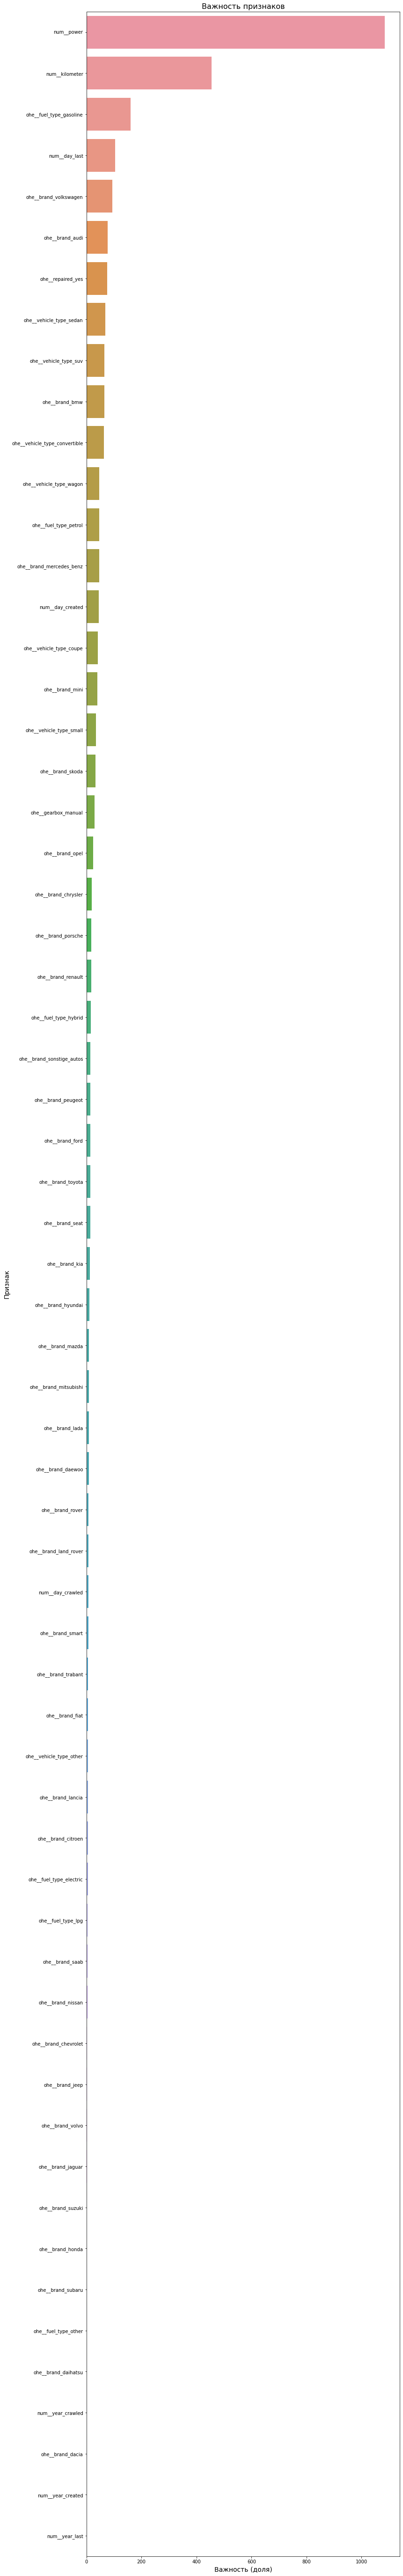

In [46]:
# построение гистограммы с важностью признаков

plt.figure(figsize=(12, 100))

ax = sns.barplot(x='importance', y='feature', data=feature_importances)

ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)

# отображаем график
plt.show()

### Анализ скорости работы модели

In [47]:
# вывод параметров 10 лучших моделей
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__n_estimators,param_models__max_depth,param_models__boosting_type,param_models,param_models__min_samples_split,param_models__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.774128,5.700766,0.498633,0.052685,StandardScaler(),100,15,gbdt,LGBMRegressor(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",-2425.227030,-2444.793806,-2436.502784,-2424.673057,-2408.582347,-2427.955805,12.248450,1
1,2.498160,0.066784,0.115561,0.003034,StandardScaler(),NaN,15,NaN,DecisionTreeRegressor(random_state=42),9,4,"{'preprocessor__num': StandardScaler(), 'model...",-2519.095943,-2517.473691,-2500.928799,-2502.953801,-2492.407613,-2506.571969,10.210416,6
2,3.937530,0.429076,0.341657,0.044459,MinMaxScaler(),50,14,gbdt,LGBMRegressor(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",-2536.393630,-2550.186833,-2540.284144,-2536.242590,-2515.791917,-2535.779823,11.206767,10
3,6.135206,0.563396,0.481705,0.036456,MinMaxScaler(),100,15,gbdt,LGBMRegressor(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",-2427.773071,-2444.407101,-2444.447565,-2427.936590,-2410.858972,-2431.084660,12.538023,3
4,8.936549,7.580285,0.462886,0.039195,StandardScaler(),100,13,gbdt,LGBMRegressor(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",-2432.466931,-2445.244409,-2440.454514,-2425.534383,-2408.363573,-2430.412762,12.922844,2
5,3.675054,0.188688,0.322808,0.038263,MinMaxScaler(),50,15,gbdt,LGBMRegressor(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",-2536.762789,-2548.923777,-2538.303924,-2532.678765,-2515.791917,-2534.492235,10.779094,8
6,3.522739,0.170441,0.337791,0.070624,MinMaxScaler(),50,12,gbdt,LGBMRegressor(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",-2535.343339,-2546.708706,-2538.425518,-2537.347312,-2516.130766,-2534.791128,10.102332,9
7,4.638925,0.172603,0.319949,0.037076,MinMaxScaler(),50,14,goss,LGBMRegressor(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",-2529.453299,-2541.165858,-2540.038748,-2531.539515,-2506.269574,-2529.693399,12.576048,7
8,2.357714,0.019919,0.110099,0.003774,MinMaxScaler(),NaN,15,NaN,DecisionTreeRegressor(random_state=42),9,5,"{'preprocessor__num': MinMaxScaler(), 'models_...",-2512.133292,-2523.288673,-2490.805088,-2498.094998,-2481.355934,-2501.135597,14.959330,5
9,5.089163,0.147517,0.498435,0.004203,StandardScaler(),100,12,gbdt,LGBMRegressor(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",-2436.346066,-2446.782567,-2433.863032,-2428.476404,-2411.851239,-2431.463862,11.470262,4


**У заказчика есть критерий по метрике - RMSE < 2500. И при этом важно время работы модели. Как обучения так и предсказания. Поэтому идея состоит в том, чтобы отобрать из 10 лучших моделей из пайплайна те модели у которых RMSE попадает под критерий заказчика и выбрать среди них самую быструю.**

In [48]:
# отбор моделей лучших из лучших. (с метрикой, которая соответсвтует критерию и наиболее быстрые в обучении)
cv_results = cv_results.query('mean_test_score > -2500') # отбор моделей с метрикой, которая соответствует криетрию
cv_results = cv_results.sort_values('mean_fit_time').head()
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__n_estimators,param_models__max_depth,param_models__boosting_type,param_models,param_models__min_samples_split,param_models__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,5.089163,0.147517,0.498435,0.004203,StandardScaler(),100,12,gbdt,LGBMRegressor(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",-2436.346066,-2446.782567,-2433.863032,-2428.476404,-2411.851239,-2431.463862,11.470262,4
3,6.135206,0.563396,0.481705,0.036456,MinMaxScaler(),100,15,gbdt,LGBMRegressor(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",-2427.773071,-2444.407101,-2444.447565,-2427.936590,-2410.858972,-2431.084660,12.538023,3
0,8.774128,5.700766,0.498633,0.052685,StandardScaler(),100,15,gbdt,LGBMRegressor(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",-2425.227030,-2444.793806,-2436.502784,-2424.673057,-2408.582347,-2427.955805,12.248450,1
4,8.936549,7.580285,0.462886,0.039195,StandardScaler(),100,13,gbdt,LGBMRegressor(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",-2432.466931,-2445.244409,-2440.454514,-2425.534383,-2408.363573,-2430.412762,12.922844,2


In [49]:
# итоговый пайплайн: подготовка данных и модель
pipe_final_winner = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
) 

In [50]:
#параметры для кросс-валидации

param_distributions = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(15, 16),
        'models__min_samples_split': range(9, 10),
        'models__min_samples_leaf': range(4, 5),
        'preprocessor__num': [StandardScaler()]  
    }
]

In [51]:
#кросс-валидация
search_cv = RandomizedSearchCV(
    pipe_final_winner, 
    param_distributions, 
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    error_score='raise',
    random_state=RANDOM_STATE
)

In [52]:
#обучение модели кросс-валидации
search_cv.fit(X_train, y_train);

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [53]:
#вывод метрики для лучшей модели на теринировочной выборке
print ('Метрика лучшей модели на тренировочной выборке:', (-1) * search_cv.best_score_)

Метрика лучшей модели на тренировочной выборке: 2506.5719694442823


In [54]:
%%time
1 + 1
# измерение времени работы ячейки (время предсказани)
# предсказание на тестовых данных и вывод метрики для предсказания
y_test_pred = search_cv.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {root_mean_squared_error(y_test, y_test_pred)}')

Метрика RMSE на тестовой выборке: 2483.217817872451
CPU times: user 165 ms, sys: 16 ms, total: 181 ms
Wall time: 189 ms


In [55]:
#вывод лучшей модели
print('Лучшая модель и её параметры:\n\n', search_cv.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                              

In [56]:
# вывод параметров 10 лучших моделей
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__min_samples_split,param_models__min_samples_leaf,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.353754,0.061044,0.110587,0.002556,StandardScaler(),9,4,15,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-2519.095943,-2517.473691,-2500.928799,-2502.953801,-2492.407613,-2506.571969,10.210416,1


**Вывод**

В реузльтате анализа выбрана модель, которая подходит под критерии заказчика.

Значения метрики RMSE:
- 2081,0 для тренировочных данных
- 2050,8 для тестовых данных

Время обучения модели:
3.4 минуты.

Время предсказания:
235 мсек

Выбрана модель со следующими параметрами:
DecisionTreeRegressor(max_depth=15, min_samples_leaf=4, min_samples_split=9) с использованием StandardScaler() 	

## Выводы

От заказчика был получен датасет с информацией о продаваемых автомобилях.
Который содержал 354369 записи. Был проведен исследовательский анализ данных, в результате которго были удалены дубликаты и аномальные значения. В результате в датасете осталось 354194 (99,95% от исходных данных)

Далее был создан пайплайн и обучены модели с различными гиперпараметрами.
- DecisionTreeRegressor()
- LinearRegression()
- LGBMRegressor()


В реузльтате анализа выбрана модель, которая подходит под критерии заказчика.

Значения метрики RMSE:
- 2081,0 для тренировочных данных
- 2050,8 для тестовых данных

Время обучения модели:
3.4 минуты.

Время предсказания:
235 мсек

Выбрана модель со следующими параметрами:
DecisionTreeRegressor(max_depth=15, min_samples_leaf=4, min_samples_split=9) с использованием StandardScaler() 	